In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json
import warnings

In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-12-13 12:40:41


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 50 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = False if USER == NAFISEH else False
CNN_ARCHITECTURE = 'ViT' # vgg16 or resnet101 or "ViT"
RNN_ARCHITECTURE = 'LSTM' # LSTM, GRU, RNN, Transformer
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = True


LOAD_SIMCLR_MODEL = True

if LOAD_SIMCLR_MODEL:
  if USER == MOIEN:
     SIMCLR_PATH = "D:\\python\\SoilNet-PreRelease\\results\\RUN_D_2023_10_11_T_00_26_Moien_SelfSupervised.pth"
  if USER == NAFISEH:
     SIMCLR_PATH = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\results\\RUN_D_2023_12_12_T_11_33_Nafiseh_SelfSupervised.pth"

if LOAD_SIMCLR_MODEL:
    if USE_LSTM_BRANCH == False:
        raise Exception("LOAD_SIMCLR_MODEL is enabled but LSTM branch is disabled. Please enable LSTM branch.")

if LOAD_SIMCLR_MODEL:
    print("\033[91m\033[1m\033[5mWARNING!\033[0m")
    print("\033[93m Loading SimCLR Model is enabled.\
        \n This will overwrite Chosen Architectures\
        \n Also, make sure that LSTM is enabled. \033[0m")
    

WARNING!
 Loading SimCLR Model is enabled.        
 This will overwrite Chosen Architectures        
 Also, make sure that LSTM is enabled. 


In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [8]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    testval_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\train'
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test'
    val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\val'
    testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images\\test_val'
    lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\Climate\\All\\filled'

In [9]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [10]:
SEQ_LEN = testval_ds_w_id[0][0][1].shape[0]
SEQ_LEN # max sequence length for Transformer model set up

61

In [11]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

11

In [12]:
from soilnet.soil_net import SoilNet, SoilNetLSTM, SoilNetSimCLRwRegHead

__name__: submodules.src.transformer.transformer


In [13]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [14]:
cv_results = {"train_loss": [],
               "val_loss": [],
               "MAE": [],
               "RMSE": [],
               "R2": []
    }

In [15]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_12_13_T_12_40


In [16]:
# SEEDS = [75] 
SEEDS = [1]  
# if USER == MOIEN else [786, 2048, 3333]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [17]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = SoilNetLSTM(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128, rnn_arch="Transformer",seq_len=SEQ_LEN).to(device)
    else:
        model = SoilNet(use_glam=USE_SPATIAL_ATTENTION, cnn_arch = CNN_ARCHITECTURE, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=1024, hidden_size=128).to(device)
    
    if LOAD_SIMCLR_MODEL:
        model = torch.load(SIMCLR_PATH).to(device)
        model = SoilNetSimCLRwRegHead(model, hidden_size=128, reg_version=REG_VERSION).to(device)
        
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['RMSE'].append(results['RMSE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    if results['MAE'][0] < best_mae:
        best_mae = results['MAE'][0]
        best_seed = seed
        print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 478/478 [01:10<00:00,  6.75it/s, Train_Loss=0.229]


 Epoch 1 Results: |  train_loss: 0.22935498003929727 |  val_loss: 0.2278619166733562  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.224]


 Epoch 2 Results: |  train_loss: 0.22373463603118474 |  val_loss: 0.23259192996698877  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.222]


 Epoch 3 Results: |  train_loss: 0.22200433994062774 |  val_loss: 0.21775816143422888  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.22] 


 Epoch 4 Results: |  train_loss: 0.21984601469718262 |  val_loss: 0.22126776606276416  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.22] 


 Epoch 5 Results: |  train_loss: 0.21950862064147095 |  val_loss: 0.22042952683092892  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.94it/s, Train_Loss=0.219]


 Epoch 6 Results: |  train_loss: 0.21871221634446328 |  val_loss: 0.23030235629150833  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.219]


 Epoch 7 Results: |  train_loss: 0.2192521304453267 |  val_loss: 0.21730549309564673  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.218]


 Epoch 8 Results: |  train_loss: 0.2182304242540104 |  val_loss: 0.21922748741032422  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.217]


 Epoch 9 Results: |  train_loss: 0.21739214208273208 |  val_loss: 0.22094281924807507  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.217]


 Epoch 10 Results: |  train_loss: 0.21744560481489453 |  val_loss: 0.22052974750598273  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.213]


 Epoch 11 Results: |  train_loss: 0.21317373689996647 |  val_loss: 0.2167170866244081  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.211]


 Epoch 12 Results: |  train_loss: 0.21076268350479493 |  val_loss: 0.21509415246006372  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.21] 


 Epoch 13 Results: |  train_loss: 0.21018855864470473 |  val_loss: 0.21259934746700784  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.95it/s, Train_Loss=0.209]


 Epoch 14 Results: |  train_loss: 0.20883421758852244 |  val_loss: 0.21407507500354794  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.02it/s, Train_Loss=0.209]


 Epoch 15 Results: |  train_loss: 0.20865956573867897 |  val_loss: 0.21292100069315537  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.96it/s, Train_Loss=0.208]


 Epoch 16 Results: |  train_loss: 0.20826156978265511 |  val_loss: 0.2121437775052112  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.208]


 Epoch 17 Results: |  train_loss: 0.20755187044832 |  val_loss: 0.2139292602305827  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.208]


 Epoch 18 Results: |  train_loss: 0.20777790912399732 |  val_loss: 0.21247850919979205  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.207]


 Epoch 19 Results: |  train_loss: 0.20718217895183105 |  val_loss: 0.21228997582110806  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.206]


 Epoch 20 Results: |  train_loss: 0.20607954168606502 |  val_loss: 0.21242679407199225  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.205]


 Epoch 21 Results: |  train_loss: 0.20500534180567354 |  val_loss: 0.21159343637418057  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.204]


 Epoch 22 Results: |  train_loss: 0.20443789096681642 |  val_loss: 0.21181010400903397  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.204]


 Epoch 23 Results: |  train_loss: 0.20382001380354292 |  val_loss: 0.21166826989771664  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.204]


 Epoch 24 Results: |  train_loss: 0.20399899652936967 |  val_loss: 0.21164791977060013  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.204]


 Epoch 25 Results: |  train_loss: 0.20384343800809093 |  val_loss: 0.21133725388326507  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.204]


 Epoch 26 Results: |  train_loss: 0.20363388272883004 |  val_loss: 0.21143443601718848  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.97it/s, Train_Loss=0.204]


 Epoch 27 Results: |  train_loss: 0.20350199050920778 |  val_loss: 0.2118869536164878  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.204]


 Epoch 28 Results: |  train_loss: 0.20361580327153206 |  val_loss: 0.21166814053836075  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.203]


 Epoch 29 Results: |  train_loss: 0.20298463612732529 |  val_loss: 0.2114922130021496  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.203]


 Epoch 30 Results: |  train_loss: 0.20317507521190903 |  val_loss: 0.21184730043877725  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.203]


 Epoch 31 Results: |  train_loss: 0.20280254214503277 |  val_loss: 0.21144361988357877  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.202]


 Epoch 32 Results: |  train_loss: 0.2023535031965587 |  val_loss: 0.21150732493918875  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.203]


 Epoch 33 Results: |  train_loss: 0.20300475204028345 |  val_loss: 0.21137980404107468  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.202]


 Epoch 34 Results: |  train_loss: 0.2023498543448528 |  val_loss: 0.2116236761212349  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 35 Results: |  train_loss: 0.2024364254776404 |  val_loss: 0.21147975249998813  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.96it/s, Train_Loss=0.203]


 Epoch 36 Results: |  train_loss: 0.2025287224127907 |  val_loss: 0.2112269039819206  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.97it/s, Train_Loss=0.202]


 Epoch 37 Results: |  train_loss: 0.20207213301788315 |  val_loss: 0.211352603914945  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.01it/s, Train_Loss=0.202]


 Epoch 38 Results: |  train_loss: 0.20239492671010884 |  val_loss: 0.21164651150288788  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.202]


 Epoch 39 Results: |  train_loss: 0.20226280286783455 |  val_loss: 0.21146365039158557  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.202]


 Epoch 40 Results: |  train_loss: 0.20189367586972823 |  val_loss: 0.21141127928875494  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 41 Results: |  train_loss: 0.20246544525526058 |  val_loss: 0.21140275539263434  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  7.00it/s, Train_Loss=0.202]


 Epoch 42 Results: |  train_loss: 0.20164016981815694 |  val_loss: 0.21161422230627225  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.203]


 Epoch 43 Results: |  train_loss: 0.20257806735869233 |  val_loss: 0.21144194253112958  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.98it/s, Train_Loss=0.202]


 Epoch 44 Results: |  train_loss: 0.2022324348312791 |  val_loss: 0.2114871376450511  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 45 Results: |  train_loss: 0.20195931350523957 |  val_loss: 0.2113133706692336  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.203]


 Epoch 46 Results: |  train_loss: 0.20266164002246437 |  val_loss: 0.21156239207240118  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 47 Results: |  train_loss: 0.20226215766002442 |  val_loss: 0.21155973718218182  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 48 Results: |  train_loss: 0.2023753281137185 |  val_loss: 0.21144870441892874  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 49 Results: |  train_loss: 0.2024727363186152 |  val_loss: 0.21153098711932916  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 478/478 [01:08<00:00,  6.99it/s, Train_Loss=0.202]


 Epoch 50 Results: |  train_loss: 0.2018115876172377 |  val_loss: 0.21123646156511444  

Adjusting learning rate of group 0 to 3.2000e-08.
Saving checkpoint=> Done!
 MAE improved to 0.14916544459270734 


In [18]:
train_arr = np.asarray(cv_results['train_loss'])
val_arr = np.asarray(cv_results['val_loss'])
train_arr.shape, val_arr.shape

((1, 50), (1, 50))

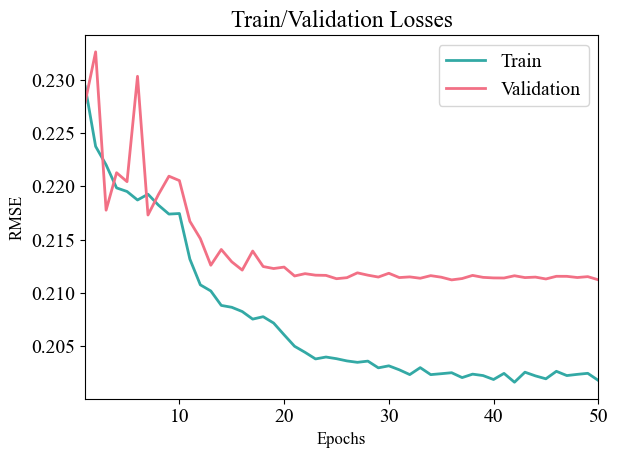

In [19]:
plot_train_test_losses(train_arr,val_arr, title="Train/Validation Losses", x_label="Epochs", y_label="RMSE",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [ ]:
import csv

In [ ]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

In [ ]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

In [ ]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

In [ ]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['CNN_ARCHITECTURE'] = CNN_ARCHITECTURE
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [ ]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [ ]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

load saved model

In [ ]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

In [ ]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [ ]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [ ]:
BATCH_N = 1

IMG_IN_BATCH = 2

In [ ]:
batch_loader = BatchLoader(test_dl_w_id)

In [ ]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

In [ ]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

In [ ]:
from plot_utils.plot import *
from PIL import Image

In [ ]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

In [ ]:
ABS_ATT = False
ALPHA = 0.4
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5))
    

    
    
    cv2.imwrite(f"results/attention_maps/final/_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

In [ ]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}") 
                #    figsize=(10,5), savepath=f"results/attention_maps/final/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # # Save img_rgband img_colormaped as jpg files
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    